In [1]:
load('CricketData.mat');

# 1) Linear Gaussian State Model for Wind Stimulus

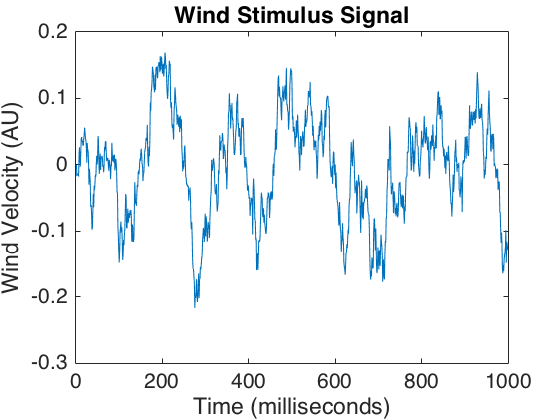

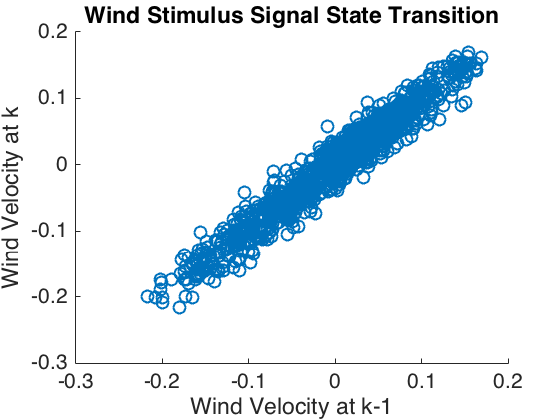

In [2]:
figure();scatter(trainingStim(1:end-1),trainingStim(2:end));
title('Wind Stimulus Signal State Transition');
xlabel('Wind Velocity at k-1');ylabel('Wind Velocity at k');

figure();plot(trainingStim);
title('Wind Stimulus Signal');xlabel('Time (milliseconds)');
ylabel('Wind Velocity (AU)');

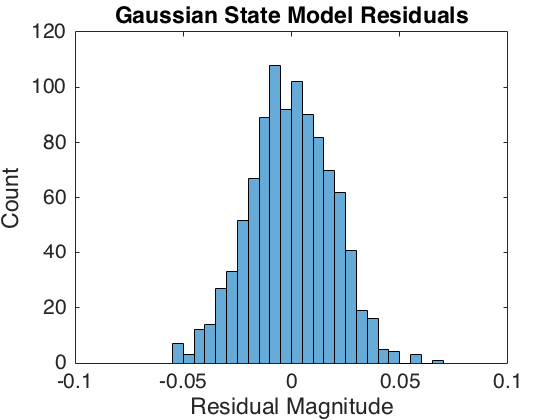

A_hat: 0.971
State transition variance: 3.641e-04


In [3]:
% solve linear regression Y = A*X
numSamples = length(trainingStim);
Y = trainingStim(2:end)';
X = trainingStim(1:end-1)';

A_hat = mldivide(X,Y);

% residuals
residuals = trainingStim(2:end)-A_hat*trainingStim(1:end-1);
figure;histogram(residuals);title('Gaussian State Model Residuals');
xlabel('Residual Magnitude');ylabel('Count');

% state transition variance
sigmasquare = var(residuals);

display(sprintf('A_hat: %3.3f\nState transition variance: %3.3e',A_hat,sigmasquare));

# 2) Inhomogeneous Poisson Process Model for Neuronal Spiking

In [4]:
numNeurons = size(trainingSpikes,1);
bigBeta = zeros(numNeurons,2);
standardErrors = zeros(numNeurons,2);
p_values = zeros(numNeurons,2);
for ii=1:numNeurons
    Y = trainingSpikes(ii,:)';
    X = trainingStim';
    [beta,dev,stats] = glmfit(X,Y,'poisson');
    bigBeta(ii,:) = beta;
    standardErrors(ii,:) = stats.se;
    p_values(ii,:) = stats.p;
end

alpha = bigBeta(:,1);beta = bigBeta(:,2);
alpha_se = standardErrors(:,1);beta_se = standardErrors(:,2);
alpha_p = p_values(:,1);beta_p = p_values(:,2);
neuronNames = cell(numNeurons,1);
for ii=1:numNeurons
    neuronNames{ii} = sprintf('Neuron_%d',ii);
end
T = table(alpha,alpha_se,alpha_p,beta,beta_se,beta_p,'RowNames',neuronNames);
display(T);

T = 

                  alpha     alpha_se     alpha_p       beta      beta_se      beta_p  
                 _______    ________    __________    _______    _______    __________

    Neuron_1     -4.1372    0.26963     3.8811e-53     8.6133    3.3228      0.0095362
    Neuron_2     -4.1337    0.27956     1.7904e-49    -11.803      2.57     4.3749e-06
    Neuron_3     -4.0366    0.26725     1.5125e-51    -12.385     2.413     2.8567e-07
    Neuron_4     -4.2094    0.29189     3.8149e-47    -12.747    2.6066     1.0074e-06
    Neuron_5     -3.9873    0.26102     1.1113e-52      11.88    3.0018     7.5732e-05
    Neuron_6     -3.8261    0.23368     2.9864e-60    -8.9249    2.3578     0.00015353
    Neuron_7     -4.7291    0.38568     1.4559e-34     13.875    4.2386      0.0010627
    Neuron_8     -4.2754    0.28559     1.1431e-50     7.7875    3.5729       0.029286
    Neuron_9     -4.6293    0.36194     1.8537e-37    -14.539    3.0674     2.1385e-06
    Neuron_10    -4.3957    0.32105 

We can see that both the alpha and beta parameters are significant for all ten neurons, given a 0.05 significance level. Neuron 8 may have the worst fit for beta, as the p-value of 0.029 is quite close to 0.05.

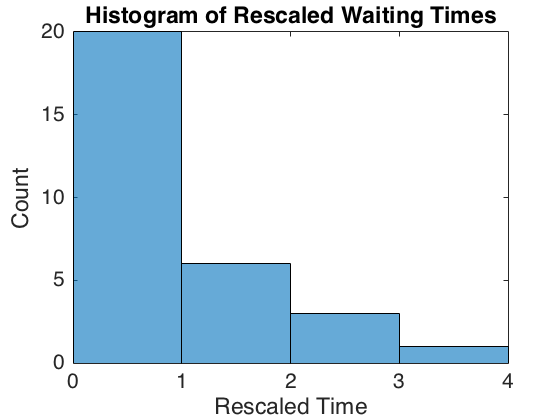

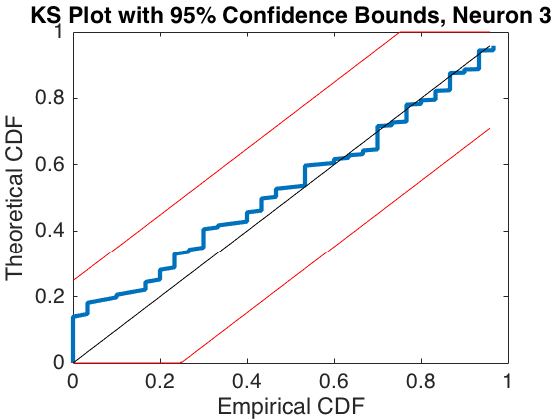

T = 

                  KSstat 
                 ________

    Neuron_1      0.13327
    Neuron_2      0.10934
    Neuron_3      0.14794
    Neuron_4     0.073792
    Neuron_5      0.19461
    Neuron_6      0.10992
    Neuron_7      0.24688
    Neuron_8      0.14185
    Neuron_9      0.12316
    Neuron_10     0.11325

Critical Value for KS stat at 95% Confidence: 0.244


In [5]:
% KS plot for goodness-of-fit with neuron 3

KSstat = zeros(numNeurons,1);
for neuronID = 1:10
    modelLambda = exp(alpha(neuronID)+beta(neuronID).*trainingStim);

    % get rescaled waiting times
    spikes = trainingSpikes(neuronID,:);
    numSpikes = sum(spikes);
    Z = zeros(numSpikes,1);
    indeces = find(spikes==1);

    lowInd = 1;
    for ii=1:numSpikes
        Z(ii) = sum(modelLambda(lowInd:indeces(ii)));
        lowInd = indeces(ii)+1;
    end

    % KS plot
    sortedISIs = sort(Z);
    ISItimes = 0:0.01:max(sortedISIs); 
    eCDF = zeros(length(ISItimes),1); 
    for ii=1:length(ISItimes)
        eCDF(ii) = sum(sortedISIs <= ISItimes(ii)); 
    end
    eCDF = eCDF./numSpikes;
    tCDF = 1-exp(-ISItimes');
    
    bounds = (1.36/sqrt(numSpikes)).*ones(length(ISItimes),1);

    if neuronID == 3
        figure();plot(eCDF,tCDF,'LineWidth',2);hold on;
        xlabel('Empirical CDF');ylabel('Theoretical CDF');
        title('KS Plot with 95% Confidence Bounds, Neuron 3');
        plot(tCDF,tCDF,'k');plot(tCDF,min(tCDF+bounds,1),'r');
        plot(tCDF,max(tCDF-bounds,0),'r');hold off;

        figure();histogram(Z);title('Histogram of Rescaled Waiting Times');
        xlabel('Rescaled Time');ylabel('Count');
    end
    KSstat(neuronID) = max(abs(eCDF-tCDF));
end
T = table(KSstat,'RowNames',neuronNames);
display(T);
criticalValue = 1.36/sqrt(numSpikes);

display(sprintf('Critical Value for KS stat at 95%% Confidence: %3.3f',criticalValue));

We can see from the KS plot for neuron 3 and the KS statistics that this model fits the observed spiking data very well for all of the neurons except neuron 7. The plot of the theoretical Exp(1) distribution against the empirical cumulative distribution function for the rescaled waiting times of neuron 3 does not go beyond the 95% confidence bounds.

# 3) Approximate Gaussian Filter 

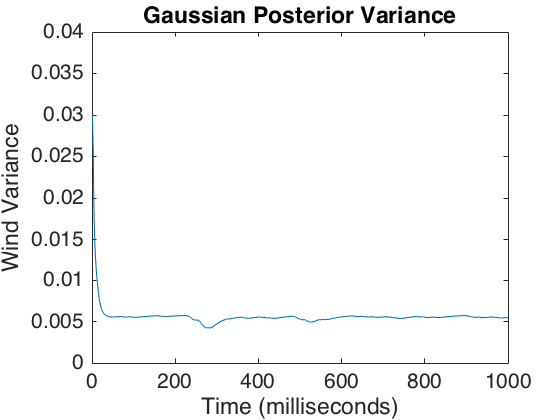

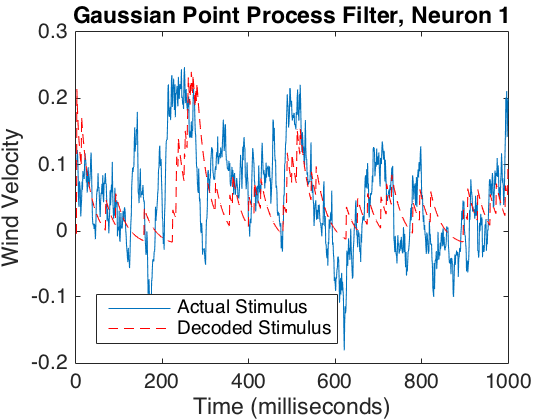

Mean-squared error: 4.908e-03
Endpoint of Posterior Variance: 5.428e-03


In [6]:
% a) decode testStim from spiking activity of neuron 1

decodedStim = zeros(numSamples+1,1);
W_hat = zeros(numSamples+1,1);W_hat(1) = 0.03;

spikes = testSpikes(1,:)';
Lambda = zeros(numSamples,1);

deltaT = 1;
% x_k | Increments_1:k-1 ~ N(A_hat*x_k-1 , A*(W_k-1)*A^T + sigmasquare)
for ii=2:numSamples+1
    % get one-step prediction mean and variance
    decodedStim(ii) = A_hat*decodedStim(ii-1);
    W_hat(ii) = A_hat*W_hat(ii-1)*A_hat+sigmasquare;
    
    % calculate lambda and derivatives at time step ii-1
    Lambda(ii-1) = exp(alpha(1)+beta(1)*decodedStim(ii));
    firstDerivLogLambda = beta(1);
    secondDerivLambda = beta(1)*beta(1)*exp(alpha(1)+beta(1)*decodedStim(ii));
    secondDerivLogLambda = 0;
    
    % update equations
    temp = 1/W_hat(ii)+secondDerivLambda*deltaT;
    W_hat(ii) = 1/temp;
    decodedStim(ii) = decodedStim(ii)+W_hat(ii)*firstDerivLogLambda*(spikes(ii-1)-Lambda(ii-1)*deltaT);
end

figure();plot(testStim);hold on;
plot(decodedStim(2:end),'r--');hold off;
legend('Actual Stimulus','Decoded Stimulus','Location','southwest');
title('Gaussian Point Process Filter, Neuron 1');
xlabel('Time (milliseconds)');ylabel('Wind Velocity');

figure();plot(W_hat);title('Gaussian Posterior Variance');
axis([0 1000 0 0.04]);
xlabel('Time (milliseconds)');ylabel('Wind Variance');

MSE = mean((testStim'-decodedStim(2:end)).^2);
display(sprintf('Mean-squared error: %3.3e',MSE));
PosteriorVariance = W_hat(end);
display(sprintf('Endpoint of Posterior Variance: %3.3e',PosteriorVariance));

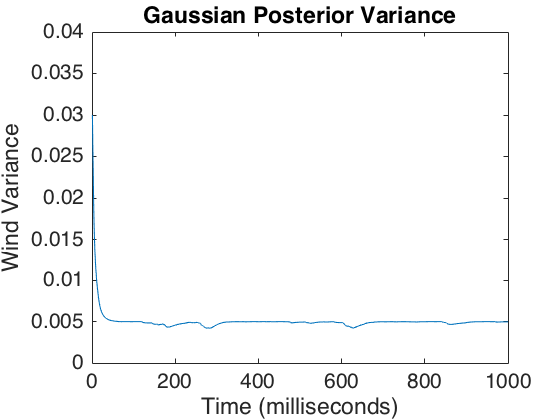

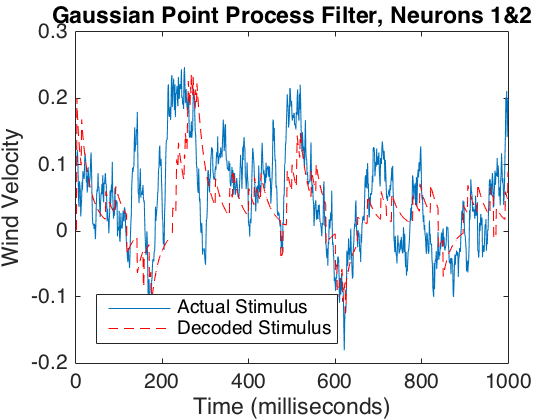

Mean-squared error: 4.793e-03
Endpoint of Posterior Variance: 4.968e-03


In [7]:
% b) decode testStim from spiking activity of neurons 1 and 2

decodedStim = zeros(numSamples+1,1);
W_hat = zeros(numSamples+1,1);W_hat(1) = 0.03;

spikes = testSpikes(1:2,:)';
Lambda = zeros(numSamples,1);

deltaT = 1;
% x_k | Increments_1:k-1 ~ N(A_hat*x_k-1 , A*(W_k-1)*A^T + sigmasquare)
for ii=2:numSamples+1
    % get one-step prediction mean and variance
    decodedStim(ii) = A_hat*decodedStim(ii-1);
    W_hat(ii) = A_hat*W_hat(ii-1)*A_hat+sigmasquare;
    
    
    tempW = 0;
    tempX = 0;
    for jj=1:2
        % calculate estimated lambda and derivatives at time step ii
        Lambda(ii-1) = exp(alpha(jj)+beta(jj)*decodedStim(ii));
        firstDerivLogLambda = beta(jj);
        secondDerivLambda = beta(jj)*beta(jj)*exp(alpha(jj)+beta(jj)*decodedStim(ii));
        secondDerivLogLambda = 0;
        
        % update sums
        tempW = tempW+secondDerivLambda*deltaT;
        tempX = tempX+firstDerivLogLambda*(spikes(ii-1,jj)-Lambda(ii-1)*deltaT);
    end
    % update equations
    W_hat(ii) = 1/(1/W_hat(ii)+tempW);
    decodedStim(ii) = decodedStim(ii)+W_hat(ii)*tempX;
end

figure();plot(testStim);hold on;
plot(decodedStim(2:end),'r--');hold off;
legend('Actual Stimulus','Decoded Stimulus','Location','southwest');
title('Gaussian Point Process Filter, Neurons 1&2');
xlabel('Time (milliseconds)');ylabel('Wind Velocity');

figure();plot(W_hat);title('Gaussian Posterior Variance');
axis([0 1000 0 0.04]);
xlabel('Time (milliseconds)');ylabel('Wind Variance');

MSE = mean((testStim'-decodedStim(2:end)).^2);
display(sprintf('Mean-squared error: %3.3e',MSE));
PosteriorVariance = W_hat(end);
display(sprintf('Endpoint of Posterior Variance: %3.3e',PosteriorVariance));

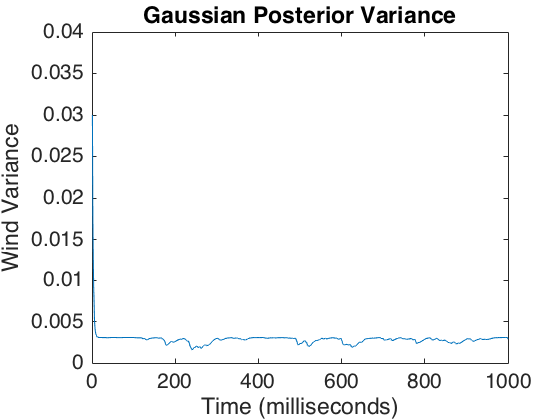

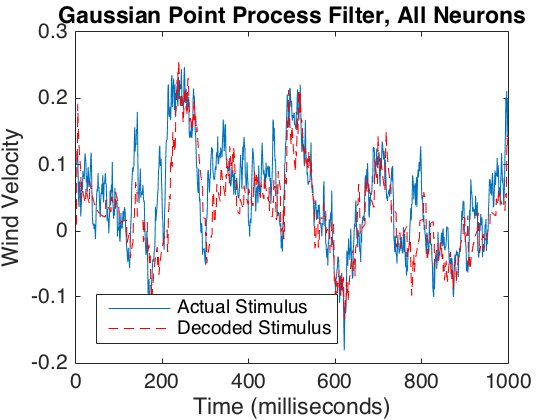

Mean-squared error: 2.781e-03
Endpoint of Posterior Variance: 2.822e-03


In [8]:
% c) decode testStim using spiking activity of all 10 neurons

decodedStim = zeros(numSamples+1,1);
W_hat = zeros(numSamples+1,1);W_hat(1) = 0.03;

spikes = testSpikes(1:end,:)';
Lambda = zeros(numSamples,1);

deltaT = 1;
% x_k | Increments_1:k-1 ~ N(A_hat*x_k-1 , A*(W_k-1)*A^T + sigmasquare)
for ii=2:numSamples+1
    % get one-step prediction mean and variance
    decodedStim(ii) = A_hat*decodedStim(ii-1);
    W_hat(ii) = A_hat*W_hat(ii-1)*A_hat+sigmasquare;
    
    tempW = 0;
    tempX = 0;
    for jj=1:10
        % calculate estimated lambda and derivatives at time step ii
        Lambda(ii-1) = exp(alpha(jj)+beta(jj)*decodedStim(ii));
        firstDerivLogLambda = beta(jj);
        secondDerivLambda = beta(jj)*beta(jj)*exp(alpha(jj)+beta(jj)*decodedStim(ii));
        secondDerivLogLambda = 0;
        
        % update sums
        tempW = tempW+secondDerivLambda*deltaT;
        tempX = tempX+firstDerivLogLambda*(spikes(ii-1,jj)-Lambda(ii-1)*deltaT);
    end
    % update equations
    W_hat(ii) = 1/(1/W_hat(ii)+tempW);
    decodedStim(ii) = decodedStim(ii)+W_hat(ii)*tempX;
end

figure();plot(testStim);hold on;
plot(decodedStim(2:end),'r--');hold off;
legend('Actual Stimulus','Decoded Stimulus','Location','southwest');
title('Gaussian Point Process Filter, All Neurons');
xlabel('Time (milliseconds)');ylabel('Wind Velocity');

figure();plot(W_hat);title('Gaussian Posterior Variance');
axis([0 1000 0 0.04]);
xlabel('Time (milliseconds)');ylabel('Wind Variance');

MSE = mean((testStim'-decodedStim(2:end)).^2);
display(sprintf('Mean-squared error: %3.3e',MSE));
PosteriorVariance = W_hat(end);
display(sprintf('Endpoint of Posterior Variance: %3.3e',PosteriorVariance));

In each case, the mean-squared error estimate is very similar to the endpoint of the posterior variance, w_hat. Thus, the model accurately tracks the error. For only one neuron, the decoded wind velocity looks quite different from the true wind velocity. The decoded values track the true values through some of the major variations, but fail to capture many subtle features of the changes. It especially fails at capturing negative values of wind velocity. We can see from the above plots that the decoding accuracy improves dramatically as the number of neurons included in the model increases, by a factor of about 2. This improvement is very clear from the graphs, where the decoded stimulus track negative values of wind velocity and the overall shape is much more accurate.

# 4) Exact Posterior Density

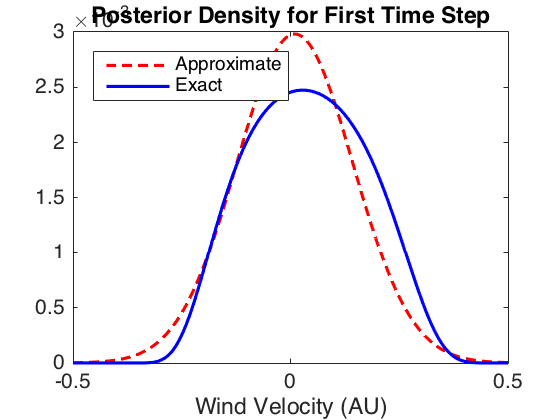

Maximum a posteriori estimate for v: 0.028
Gaussian estiamte for v: 0.010


In [9]:
% first time step
velocities = -0.5:0.001:0.5;
normApprox = normpdf(velocities,decodedStim(2),sqrt(W_hat(2)));
figure();plot(velocities,normApprox./sum(normApprox),'r--','LineWidth',1.5);hold on;

numNeurons = 10;
prior = ones(length(velocities),1)./length(velocities);
% calculate likelihood
likelihood = ones(length(velocities),1);
deltaT = 1;
for ii=1:length(velocities)
    for jj=1:numNeurons
        lambda = exp(alpha(jj)+beta(jj)*velocities(ii));
        likelihood(ii) = likelihood(ii).*(lambda*deltaT).^testSpikes(jj,1).*exp(-lambda*deltaT);
    end
end

% calculate integral 
integral = zeros(length(velocities),1);
for ii=1:length(velocities)
    oneStepPDF = normpdf(velocities,A_hat*velocities(ii),sqrt(sigmasquare));
    integral(ii) = integral(ii)+sum(oneStepPDF'.*prior.*0.001);
end
posterior = likelihood.*integral;posterior = posterior./sum(posterior);
plot(velocities,posterior,'b','LineWidth',1.5);
title('Posterior Density for First Time Step');xlabel('Wind Velocity (AU)');
legend('Approximate','Exact','Location','northwest');

[~,ind] = max(posterior);
display(sprintf('Maximum a posteriori estimate for v: %3.3f',velocities(ind)));
display(sprintf('Gaussian estiamte for v: %3.3f',decodedStim(2)));

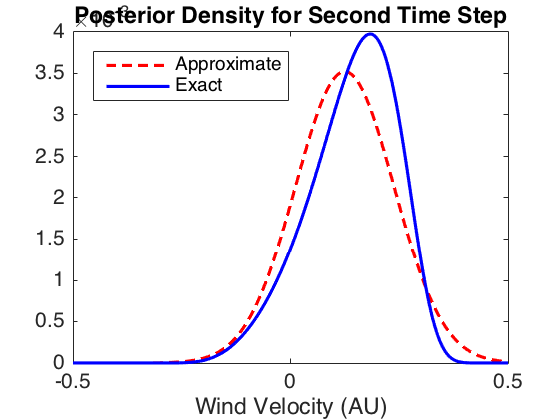

Maximum a posteriori estimate for v: 0.183
Gaussian estiamte for v: 0.125


In [10]:
% second time step
velocities = -0.5:0.001:0.5;
normApprox = normpdf(velocities,decodedStim(3),sqrt(W_hat(3)));
figure();plot(velocities,normApprox./sum(normApprox),'r--','LineWidth',1.5);hold on;

numNeurons = 10;
prior = ones(length(velocities),1)./length(velocities);
% calculate likelihood
likelihood = ones(length(velocities),1);
deltaT = 1;
for ii=1:length(velocities)
    for jj=1:numNeurons
        lambda = exp(alpha(jj)+beta(jj)*velocities(ii));
        likelihood(ii) = likelihood(ii).*(lambda*deltaT).^testSpikes(jj,2).*exp(-lambda*deltaT);
    end
end

% calculate integral 
integral = zeros(length(velocities),1);
for ii=1:length(velocities)
    oneStepPDF = normpdf(velocities,A_hat*velocities(ii),sqrt(sigmasquare));
    integral(ii) = integral(ii)+sum(oneStepPDF'.*posterior.*0.001);
end
posterior = likelihood.*integral;posterior = posterior./sum(posterior);
plot(velocities,posterior,'b','LineWidth',1.5);
title('Posterior Density for Second Time Step');xlabel('Wind Velocity (AU)');
legend('Approximate','Exact','Location','northwest');

[~,ind] = max(posterior);
display(sprintf('Maximum a posteriori estimate for v: %3.3f',velocities(ind)));
display(sprintf('Gaussian estiamte for v: %3.3f',decodedStim(3)));

We can see from the above plots, which compare the Gaussian approximation to the exact posterior density for predicted wind velocity, that the Gaussian approximation is quite good. Looking at the maximum a posteriori estiamte for wind velocity in each case, we see that this best estimate falls within the "meat" of the Gaussian distribution. However, it is clear that the exact posterior density is not Gaussian. In timestep 2, for example, the exact posterior distribution has negative skew and is therefore not symmetric like a Gaussian.